# Simple Percepton Network

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For random number generation
from scipy.stats import norm
from scipy.stats import expon

### (1) Define generation procedure for normal and exponential distribution

In [2]:
# Normal distribution with correlation

def mynorm(Nmc,pos,sig,corr=0.0):

    data = np.empty(shape=(Nmc,2))
    
    phi = 0.5*np.arcsin(corr)

    g = np.random.normal(size=(2,Nmc))

    data[:,0] = pos[0] + sig[0]*(g[0]*np.cos(phi) + g[1]*np.sin(phi))
    data[:,1] = pos[1] + sig[1]*(g[0]*np.sin(phi) + g[1]*np.cos(phi))
    
    return data

# Exponential distribution with correlation

def myexpo(Nmc,pos,sig,corr=0.0):

    data = np.empty(shape=(Nmc,2))
    
    phi = 0.5*np.arcsin(corr)

    g = np.random.normal(size=(2,Nmc))

    r1_tab = g[0]*np.cos(phi) + g[1]*np.sin(phi)
    r2_tab = g[0]*np.sin(phi) + g[1]*np.cos(phi)

# Convert correlated gaussian variables r1 & r2 
# to correlated exponential variables, based on survival function

    s1_tab = norm.sf(r1_tab)
    s2_tab = norm.sf(r2_tab)
    
    data[:,0] = pos[0] + sig[0]*expon.isf(s1_tab)
    data[:,1] = pos[1] + sig[1]*expon.isf(s2_tab)
    
    return data

### (2) Generating training and test data

In [67]:
# Sample size

Ntrain = 1000
Ntest = 1000

# Two hypothesis:

# H1: Exponential background

h1 = np.array([-1.,-1.])
sig1 = np.array([2.0,2.0])
corr1 = 0

# H2: Normal distribution for signal

h2 = np.array([1.,1.])
sig2 = np.array([0.3,0.3])
corr2 = 0

# Fraction of first hypothesis

fh1 = 0.5

# Generate train sample 
# ---------------------

h1train = myexpo(Ntrain,h1,sig1,corr1)
h2train = mynorm(Ntrain,h2,sig2,corr2)

# Uniform distributed numbers

rtrain = np.random.uniform(size=Ntrain)

# Mix of two hypothesis

y_train = rtrain > fh1

y2_train = np.resize(np.repeat(y_train,2),(Ntrain,2))

X_train = y2_train * h1train + (1 - y2_train)*h2train

print("Train data defined, size: ",y_train.size)

# Generate test sample 
# --------------------

h1test = myexpo(Ntest,h1,sig1,corr1)
h2test = mynorm(Ntest,h2,sig2,corr2)

# Uniform distributed numbers

rtest = np.random.uniform(size=Ntest)

# Mix of two hypothesis

y_test = rtest > fh1

y2_test = np.resize(np.repeat(y_test,2),(Ntest,2))

X_test = y2_test * h1test + (1 - y2_test)*h2test

print("Test data defined, size: ",y_test.size)

# Rescale category from {0,1} to {-1,1}

y_train = 2*y_train - 1
y_test = 2*y_test - 1

Train data defined, size:  1000
Test data defined, size:  1000


### (3) Iterative approach

In [68]:
# Number of nodes in hidden layer

Nh = 2

# Start from random weights and offset

# Output node weights

w1vec = np.random.uniform(size=Nh)-0.5
w1cut = np.random.uniform()-0.5

# Wights for two hiden nodes

w2vec = np.random.uniform(size=(Nh,2))-0.5
w2cut = np.random.uniform(size=Nh)-0.5


In [69]:
# Initial prediction

hpred = np.tanh(X_train @ np.transpose(w2vec) - w2cut)
ypred  = np.tanh( (hpred @ w1vec) - w1cut) 

dy = ypred - y_train
dist = np.sum(dy*dy)
nok = np.sum(ypred*y_train > 0)

print("Initial distance: ",np.sqrt(dist),", ",nok," events properly classified")


Initial distance:  34.259847257134645 ,  495  events properly classified


In [70]:
# Iteration starting step

eta = 1.

it = 0
dmin = dist
  
while True :

    it+=1
    
    # Adjust output layer weights
    
    dy1 = (1+ypred)*(1-ypred)*dy
    dw1 = dy1 @ hpred

    c1new = w1cut + eta/Ntrain * np.sum(dy1)
    w1new = w1vec - eta/Ntrain * dw1
    
    # Adjusting hidden layers weights
    
    dh2 = (1+hpred)*(1-hpred)*np.outer(dy1,w1vec)
    dw2 = np.transpose(dh2) @ X_train
    c2new = w2cut + eta/Ntrain * np.sum(dh2,axis=0) 
    w2new = w2vec - eta/Ntrain * dw2
    
    hpred = np.tanh(X_train @ np.transpose(w2new) - c2new)
    ypred  = np.tanh( (hpred @ w1new) - c1new) 

    nok = np.sum(ypred*y_train > 0)

    dy = ypred - y_train
    dist = np.sum(dy*dy)

    if dist < dmin :
        w1cut = c1new
        w1vec = w1new
        w2cut = c2new
        w2vec = w2new
        eta *= 2.0
        dmin = dist
        
# Debug printout
#        print(it,eta,w1new,w2new,c1new,c2new,nok,dist)
  
    else:
        eta /= 2.
        
    if eta < 0.0000001 : break
    
    if nok == Ntrain : break
    
    if it == 1000 : break

  
# Normalized direction vector

print(it," iterations, final distance: ",np.sqrt(dist),", ",nok," events properly classified")

# Check test sample

hpred = np.tanh(X_test @ np.transpose(w2vec) - w2cut)
ypred  = np.tanh( (hpred @ w1vec) - w1cut) 
    
nok = np.sum(ypred*y_test > 0)

print(nok," events properly classified for test sample")


1000  iterations, final distance:  19.605265885444012 ,  871  events properly classified
904  events properly classified for test sample


In [71]:
ai = -w2vec[:,0]/w2vec[:,1]
bi = w2cut/w2vec[:,1]

print("Discriminant line: y = ",ai," * x  +  ",bi)


Discriminant line: y =  [1.31480423 2.84583415]  * x  +   [-0.85982078 -0.93108466]


### (4) Plot results

In [72]:
# 2D grid for decision histogram (as background)

Xmin = -1.0
Xmax = 5.0
Nbin = 120
dX = (Xmax-Xmin)/Nbin

Xrange = np.linspace(Xmin+0.5*dX,Xmax-0.5*dX,Nbin)

X1grid, X2grid = np.meshgrid(Xrange,Xrange)

yval = np.empty(X1grid.shape)

# Loop over 2D grid
    
for i in range(Nbin):
    for j in range(Nbin):

        x1 = X1grid[i,j]  
        x2 = X2grid[i,j]      
        
        X = np.array([x1,x2])
        hpred = np.tanh(X @ np.transpose(w2vec) - w2cut)
        yval[i,j]  = ( (hpred @ w1vec) - w1cut) > 0.


In [73]:
# Hidden node decision lines

Np = 2

Xfun = np.linspace(Xmin,Xmax,Np)

# Discriminant line from the generated sample and from the distribution parameters

Yfun = np.outer(Xfun,ai)+bi


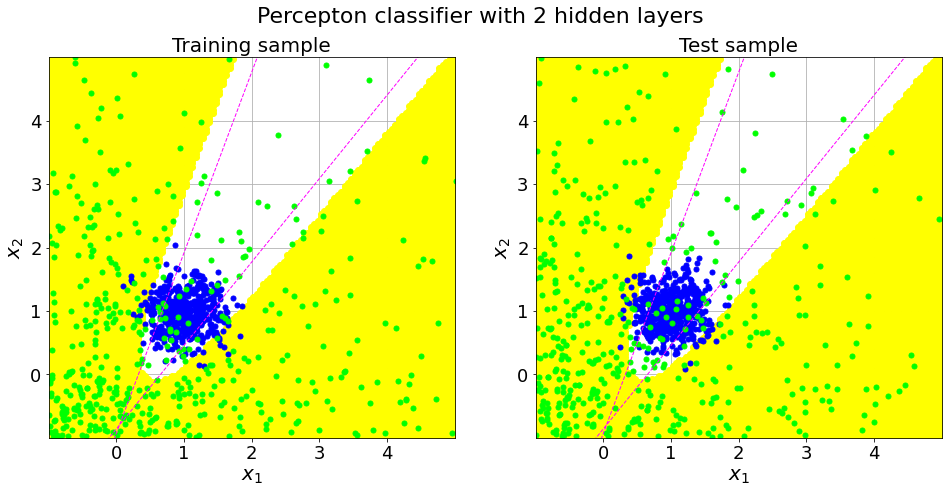

In [74]:
# Create result graph

Xmin = -0.999
Xmax = 4.999

plt.subplots(1,2,figsize=(16, 7))

plt.suptitle("Percepton classifier with "+str(Nh)+" hidden layers",fontsize=22)

# Train sample

plt.subplot(121)

# Decision pattern as background

plt.plot(X1grid[yval==1],X2grid[yval==1],'o',color='yellow')
plt.xlim([Xmin,Xmax])
plt.ylim([Xmin,Xmax])

# Training points in two categories

plt.plot(X_train[:,0][y_train==-1],X_train[:,1][y_train==-1],'o',color='blue',ms=5)
plt.plot(X_train[:,0][y_train==1],X_train[:,1][y_train==1],'o',color='lime',ms=5)

if Nh<10 :
    for ih in range(Nh):
        plt.plot(Xfun,Yfun[:,ih],'--',color='magenta',linewidth=1)

plt.title("Training sample",size=20)
plt.xlabel('$x_1$',size=20)
plt.ylabel('$x_2$',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

# Test sample

plt.subplot(122)

# Decision pattern as background

plt.plot(X1grid[yval==1],X2grid[yval==1],'o',color='yellow')
plt.xlim([Xmin,Xmax])
plt.ylim([Xmin,Xmax])

# Test points in two categories

plt.plot(X_test[:,0][y_test==-1],X_test[:,1][y_test==-1],'o',color='blue',ms=5)
plt.plot(X_test[:,0][y_test==1],X_test[:,1][y_test==1],'o',color='lime',ms=5)
if Nh<10 :
    for ih in range(Nh):
        plt.plot(Xfun,Yfun[:,ih],'--',color='magenta',linewidth=1)

plt.title("Test sample",size=20)
plt.xlabel('$x_1$',size=20)
plt.ylabel('$x_2$',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')


fname = '13_NN_'+str(Nh)+'.png'

plt.savefig(fname)

plt.show()